In [2]:
import gymnasium as gym
# import gym_snake_game
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import copy

In [3]:
# env = gym.make('MountainCar-v0', render_mode='rgb_array')
# env = gym.make('CarRacing-v2', render_mode='rgb_array')
env = gym.make("CartPole-v1", render_mode='rgb_array')

In [4]:
# rough
env.reset()[0].shape

(4,)

In [5]:
a = np.array([1,2,3])
random.shuffle(a)
a

array([3, 1, 2])

In [6]:
def make_game_video(env, model=None , MAX_DUR=1000):
    img_array = []
    size = None
    env.reset()
    img_array.append(env.render())
    for i in range(MAX_DUR):
        if model == None:
            action = env.action_space.sample()
        else :
            pass
        state = env.step(action)[0]
        img = env.render()
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_array.append(img)
    
    size = img_array[0].shape
    size = size[:2]
#     print(img_array[0].dtype)
    vid = cv2.VideoWriter('game_vid.avi' , cv2.VideoWriter_fourcc(*'DIVX'), fps=15 ,frameSize=size)
    for i in img_array:
        vid.write(i)
    vid.release()

In [ ]:
make_game_video(env)

In [ ]:
np.expand_dims(env.reset()[0], axis=0)

In [7]:
def make_model():
    inps = keras.layers.Input(shape=(4))
#     x = keras.layers.Flatten()(inp)
    x = keras.layers.Dense(200, activation='relu')(inps)
#     x = keras.layers.Dense(100, activation='relu')(inps)
#     x = keras.layers.Dense(200, activation='relu')(x)
#     x = keras.layers.Dense(100, activation='relu')(x)
    outs = keras.layers.Dense(2, activation='softmax')(x)
    model = keras.Model(inputs=inps , outputs=outs)
    return model

In [ ]:
model = make_model()
s = env.reset()[0]
print(s)
# s = process_state(s)
model(np.array([s]))

In [ ]:
# env.step(np.array(model(np.array([[s,s,s,s]]))))

In [8]:
def discount_reward(rewards, gamma=0.99):
    disc_r = tf.pow(gamma, np.arange(len(rewards))) * rewards
    r = tf.math.reduce_sum(disc_r)
    
def process_state(state):
    return state
    return np.expand_dims(state, axis=0)
    
def e_greedy(action_prob, e = 0.01):
    if random.random()<e:
        return random.randint(0,len(action_prob)-1)
    else :
        return np.argmax(action_prob)

In [ ]:
# SIMPLE TRAINING:

model = make_model()

optim = keras.optimizers.Adam(learning_rate=0.001)

epochs = 100
episode_len = 200

gamma = 0.9
loss_history = []

for epoch in range(epochs):
    state = env.reset()[0]
    state = process_state(state)
#     state = np.array(state)
    done = False
    t = 0
    G = 0
    losses = []
    while t<episode_len and (not done):
        print(state)
        action_prob = model(np.array([state]))[0]
#         print(action_prob)
#         action = e_greedy(action_prob)
        action = np.random.choice([0,1], p=np.array(action_prob))
#         print(action)
        prev_state = state
        state , reward, done, _ , info = env.step(action)
        state = process_state(state)
        G += reward*tf.pow(gamma, t)
        t+=1
        target = tf.Variable(tf.zeros(len(action_prob[0])))
#         print(target)
        target[action].assign(1)
#         print('target : ', target)
        with tf.GradientTape() as tape:
            action_prob = model(np.array([prev_state]))[0]
            loss = tf.reduce_sum(tf.math.log(tf.pow(target-action_prob,2)) / G)
        gradients = tape.gradient(loss, model.trainable_weights)
#         print("loss: ",loss)
#         print("gradients : " ,gradients)
        losses.append(loss.numpy())
        optim.apply_gradients(zip(gradients, model.trainable_weights))
    loss_history.append(np.sum(losses)/len(losses))
plt.plot(loss_history)

In [ ]:
print(done, t, G)
plt.plot(loss_history)

In [ ]:
plt.imshow(env.render())

In [ ]:
state = env.reset()[0]
done = False
for i in range(500):
    action = np.argmax(model(process_state(np.array([state])))[0])
    _ = env.step(action)
    done = _[2]
    if done or _[3]:
        break;
    state = _[0]
print(i)

In [ ]:
plt.imshow(env.render())

In [ ]:
# from gym.wrappers.monitoring.video_recorder import VideoRecorder
# import gym
# max_time = 200
# record_env = RecordVideo(env , './mp4', video_length=max_time)

# state = env.reset()[0]
# state = process_state(state)
# ans = 0
# done = False

# while ans < max_time and done==False:
#     action = np.argmax(model(np.array([state]))[0])
#     state , r , done,_ ,__ = record_env.step(action)
#     state = process_state(state)
#     ans += 1

# record_env.close()
# print(done)
# print(ans)

In [ ]:
env.close()

In [ ]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = np.power(gamma,np.arange(lenr)) * rewards 
    disc_return /= disc_return.max() 
    return disc_return

2023-02-27 13:45:01.451933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 13:45:01.477536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 13:45:01.477899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 13:45:01.478847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

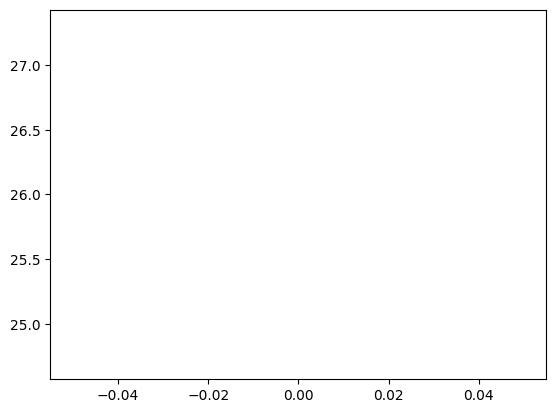

In [9]:
# TRAINING WITH EXPERIENCE REPLAY:

model = make_model()

env = gym.make("CartPole-v1", render_mode='rgb_array')

optimizer = keras.optimizers.RMSprop(learning_rate=0.001)


epochs = 1
episode_len = 200

gamma = 0.99
loss_history = []
e = 0.01

for epoch in range(epochs):
    state1 = env.reset()[0]
    done = False
    t = 0
    replay = []
    if epoch%60 == 0:
        e/=10
        
    for t in range(episode_len):
        t+=1
        action_prob = model(np.array([state1]))[0]
#         print(action_prob)
        action = np.random.choice([0,1], p=np.array(action_prob))
#         action = e_greedy(action_prob, e)
        state2 , r, done , truncated , info = env.step(action)
        experience = [state1, action , t+1]
        replay.append(experience)
        state1 = state2
        if done :
            break
    
    action_batch = [a for (s,a,r) in replay]
    state_batch = [s for (s,a,r) in replay]
    reward_batch = [r for (s,a,r) in replay]
    
    reward_batch = np.array(reward_batch[::-1])
    g = np.power(gamma, np.arange(t))*reward_batch
    g = g/np.max(g)
    
    with tf.GradientTape() as tape:
        pred_batch = model(np.array(state_batch),  training=True)
        prob_batch = tf.gather_nd(pred_batch , indices=[[i,j] for i,j in enumerate(action_batch)])
        loss = -tf.reduce_sum(g * tf.math.log(prob_batch))
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    loss_history.append(t)
    
plt.plot(loss_history)

In [ ]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = np.power(gamma,np.arange(lenr)) * rewards 
    disc_return /= disc_return.max() 
    return disc_return

inputs = keras.layers.Input(4)
x = keras.layers.Dense(200, activation = 'relu')(inputs)
# x = keras.layers.Dense(200 , activation = 'relu')(x)
outputs = keras.layers.Dense(2, activation = 'softmax')(x)

model = make_model()

optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

env = gym.make("CartPole-v1")

EPOCHS = 300

history = []
for play in range(EPOCHS):
    MAX_DUR = 200
    state1 = env.reset()[0]
    transitions = []

    for t in range(MAX_DUR):
        action_prob = model(np.array([state1]))
        action_prob = np.squeeze(action_prob)
        action = np.random.choice([0,1], p=action_prob)
        _ = env.step(action)
        state2 = _[0]
        #reward = _[1]
        done = _[2]
        transitions.append([state1, action, state2, t+1])
        if done :
            break

        state1 = state2
    ep_len = len(transitions)
    reward_batch = [r for (s1,a,s2,r) in transitions]
    reward_batch = np.array(reward_batch[::-1])
    state_batch = [s1 for (s1,a,s2,r) in transitions]
    state_batch = np.array(state_batch)
    action_batch = [a for (s1,a,s2,r) in transitions]
    action_batch = np.array(action_batch)
    
    gamma = 0.99
    
    reward = discount_rewards(reward_batch)
    
    with tf.GradientTape() as tape:
        pred_batch = model(state_batch,  training=True)
        prob_batch = tf.gather_nd(pred_batch , indices=[[i,j] for i,j in enumerate(action_batch)])
        loss = -tf.reduce_sum(reward * tf.math.log(prob_batch))
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    history.append(ep_len)

#     def loss_fn(preds, r): 
#         return -1 * np.sum(r * np.log(preds)) 
    
#     def discount_rewards(rewards, gamma=0.99):
#         lenr = len(rewards)
#         disc_return = np.power(gamma,np.arange(lenr)) * rewards 
#         disc_return /= disc_return.max() 
#         return disc_return


# history = train_loop(model)
plt.plot(history)

In [ ]:
o = 0
z = 0
n = 1000
for i in range(n):
    if np.random.choice([0,1], p=[0.6,0.4]) == 0:
        z+=1
    else :
        o += 1
print(z/n,  o/n)